## Outline

* Recap of data
* Feedforward network with Pytorch tensors and autograd
* Using Pytorch's NN -> Functional, Linear, Sequential & Pytorch's Optim
* Moving things to CUDA

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import time
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_blobs

import torch

In [2]:
torch.manual_seed(0)

In [3]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

## Generate Dataset

In [4]:
data, labels = make_blobs(n_samples=1000, centers=4, n_features=2, random_state=0)
print(data.shape, labels.shape)

(1000, 2) (1000,)


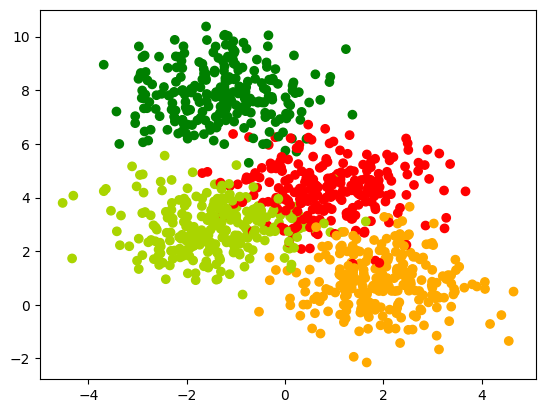

In [5]:
plt.scatter(data[:,0], data[:,1], c=labels, cmap=my_cmap)
plt.show()

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, X_val.shape, labels.shape)

(750, 2) (250, 2) (1000,)


## Using torch tensors and autograd

In [7]:
X_train, Y_train, X_val, Y_val = map(torch.tensor, (X_train, Y_train, X_val, Y_val))

In [8]:
print(X_train.shape, Y_train.shape)

torch.Size([750, 2]) torch.Size([750])


In [9]:
def model(x):
  a1 = torch.matmul(x, weights1) + bias1 # (N, 2) x (2, 2) -> (N, 2)
  h1 = a1.sigmoid() # (N, 2)
  a2 = torch.matmul(h1, weights2) + bias2 # (N, 2) x (2, 4) -> (N, 4)
  h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1) # (N, 4)
  return h2

In [10]:
y_hat = torch.tensor([[0.1, 0.2, 0.3, 0.4], [0.8, 0.1, 0.05, 0.05]])
y = torch.tensor([2, 0])

(-y_hat[range(y_hat.shape[0]), y].log()).mean().item()

(torch.argmax(y_hat, dim=1) == y).float().mean().item()

0.5

In [11]:
def loss_fn(y_hat, y):
  return -(y_hat[range(y.shape[0]), y].log()).mean()

In [12]:
def accuracy(y_hat, y):
  pred = torch.argmax(y_hat, dim=1)
  return (pred == y).float().mean()

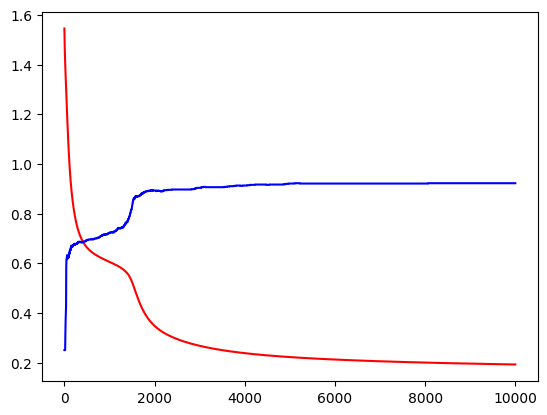

Loss before training 1.5456440448760986
Loss after training 0.19288595020771027


In [13]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

X_train = X_train.float()
Y_train = Y_train.long()

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = loss_fn(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

## Using NN.Functional

In [14]:
import torch.nn.functional as F

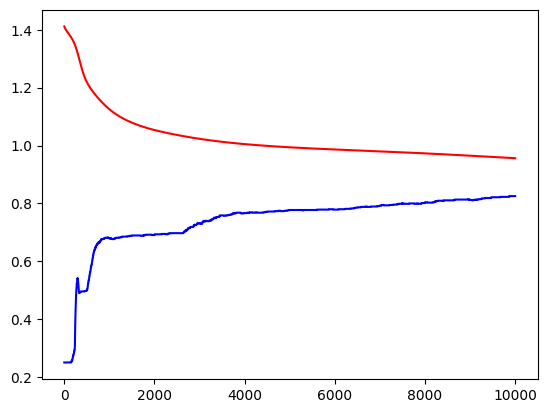

Loss before training 1.4111982583999634
Loss after training 0.9561847448348999


In [15]:
torch.manual_seed(0)
weights1 = torch.randn(2, 2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad=True)

weights2 = torch.randn(2, 4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad=True)

learning_rate = 0.2
epochs = 10000

loss_arr = []
acc_arr = []

for epoch in range(epochs):
  y_hat = model(X_train)
  loss = F.cross_entropy(y_hat, Y_train)
  loss.backward()
  loss_arr.append(loss.item())
  acc_arr.append(accuracy(y_hat, Y_train))

  with torch.no_grad():
    weights1 -= weights1.grad * learning_rate
    bias1 -= bias1.grad * learning_rate
    weights2 -= weights2.grad * learning_rate
    bias2 -= bias2.grad * learning_rate
    weights1.grad.zero_()
    bias1.grad.zero_()
    weights2.grad.zero_()
    bias2.grad.zero_()

plt.plot(loss_arr, 'r-')
plt.plot(acc_arr, 'b-')
plt.show()
print('Loss before training', loss_arr[0])
print('Loss after training', loss_arr[-1])

## Using NN.Parameter

In [16]:
import torch.nn as nn

In [17]:
class FirstNetwork(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.weights1 = nn.Parameter(torch.randn(2, 2) / math.sqrt(2))
    self.bias1 = nn.Parameter(torch.zeros(2))
    self.weights2 = nn.Parameter(torch.randn(2, 4) / math.sqrt(2))
    self.bias2 = nn.Parameter(torch.zeros(4))
    
  def forward(self, X):
    a1 = torch.matmul(X, self.weights1) + self.bias1
    h1 = a1.sigmoid()
    a2 = torch.matmul(h1, self.weights2) + self.bias2
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

In [18]:
def fit(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    with torch.no_grad():
      for param in fn.parameters():
        param -= learning_rate * param.grad
      fn.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

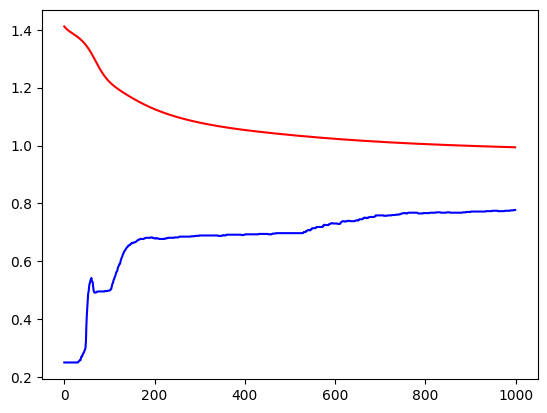

Loss before training 1.4111982583999634
Loss after training 0.9939236044883728


In [19]:
fn = FirstNetwork()
fit()

## Using NN.Linear and Optim

In [20]:
class FirstNetwork_v1(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.lin1 = nn.Linear(2, 2)
    self.lin2 = nn.Linear(2, 4)
    
  def forward(self, X):
    a1 = self.lin1(X)
    h1 = a1.sigmoid()
    a2 = self.lin2(h1)
    h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
    return h2

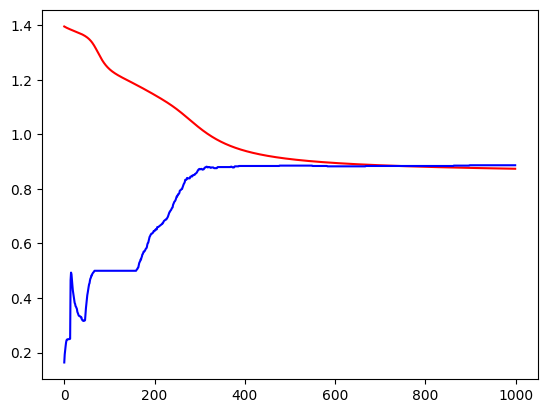

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [21]:
fn = FirstNetwork_v1()
fit()

In [22]:
from torch import optim

In [23]:
def fit_v1(epochs = 1000, learning_rate = 1):
  loss_arr = []
  acc_arr = []
  opt = optim.SGD(fn.parameters(), lr=learning_rate)
  
  for epoch in range(epochs):
    y_hat = fn(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))

    loss.backward()
    opt.step()
    opt.zero_grad()
        
  plt.plot(loss_arr, 'r-')
  plt.plot(acc_arr, 'b-')
  plt.show()      
  print('Loss before training', loss_arr[0])
  print('Loss after training', loss_arr[-1])

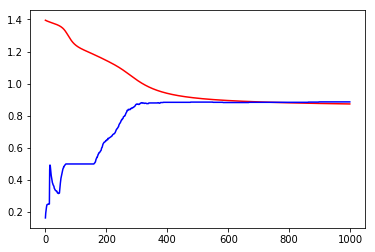

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [58]:
fn = FirstNetwork_v1()
fit_v1()

## Using NN.Sequential

In [ ]:
class FirstNetwork_v2(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2, 2), 
        nn.Sigmoid(), 
        nn.Linear(2, 4), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

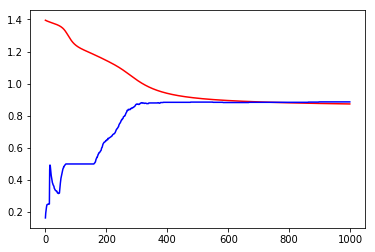

Loss before training 1.395160436630249
Loss after training 0.8738410472869873


In [62]:
fn = FirstNetwork_v2()
fit_v1()

In [ ]:
def fit_v2(x, y, model, opt, loss_fn, epochs = 1000):
  
  for epoch in range(epochs):
    loss = loss_fn(model(x), y)

    loss.backward()
    opt.step()
    opt.zero_grad()
    
  return loss.item()

In [65]:
fn = FirstNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr=1)
fit_v2(X_train, Y_train, fn, opt, loss_fn)

0.8738410472869873

## Running it on GPUs

In [86]:
device = torch.device("cuda")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v2()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.395159363746643
Time taken 0.7891602516174316


In [ ]:
class FirstNetwork_v3(nn.Module):
  
  def __init__(self):
    super().__init__()
    torch.manual_seed(0)
    self.net = nn.Sequential(
        nn.Linear(2, 1024*4), 
        nn.Sigmoid(), 
        nn.Linear(1024*4, 4), 
        nn.Softmax()
    )

  def forward(self, X):
    return self.net(X)

In [93]:
device = torch.device("cpu")

X_train=X_train.to(device)
Y_train=Y_train.to(device)
fn = FirstNetwork_v3()
fn.to(device)
tic = time.time()
print('Final loss', fit_v2(X_train, Y_train, fn, opt, loss_fn))
toc = time.time()
print('Time taken', toc - tic)

Final loss 1.3890225887298584
Time taken 29.352728128433228


## Exercises

1. Try out a deeper neural network, eg. 2 hidden layers
2. Try out different parameters in the optimizer (eg. try momentum, nestrov) -> check `optim.SGD` docs
3. Try out other optimization methods (eg. RMSProp and Adam) which are supported in `optim`
4. Try out different initialisation methods which are supported in `nn.init` 